In [2]:
import pandas as pd
import numpy as np

In [3]:
# 2014 ~ 2018
df_1 = pd.read_csv('./2014_2018.csv')

# 컬럼명 동일시
df_1.rename(columns = {'총계_계':'총계', '구분_시도' : '시도', '구분_시군구' : '시군구'},inplace=True)

# 지역별 폐기물 총계
# 2014 ~ 2018 년도 폐기물 총계
df_14_18 = df_1[['YEAR','시도','시군구','총계_매립','총계_소각','총계_재활용','총계']]

# 2019 ~ 2021
df_2 = pd.read_csv('./2019_2021.csv')

# 컬럼명 동일시
df_2.rename(columns = {'2019년 발생량':'총계'},inplace=True)

# 2019 ~ 2021 년도 폐기물 총계
df_19_21 = df_2.loc[(df_2['폐기물 종류_대']=='합계')&(df_2['시군구']!='소계')
                    ,['YEAR','시도','시군구','총계_매립','총계_소각','총계_재활용','총계']]

# union
df = pd.concat([df_14_18, df_19_21]).reset_index(drop=True)

# 백업
df_bak = df.copy()


In [4]:
# 시도 약어 변환 사전
sido_dict = {
 '경기' : '경기도'  
,'서울' : '서울특별시'
,'경북' : '경상북도'
,'전남' : '전라남도'
,'경남' : '경상남도'
,'강원' : '강원도'
,'부산' : '부산광역시'
,'충남' : '충청남도'
,'전북' : '전라북도'
,'인천' : '인천광역시'
,'충북' : '충청북도'
,'대구' : '대구광역시'
,'광주' : '광주광역시'
,'대전' : '대전광역시'
,'울산' : '울산광역시'
,'제주' : '제주특별자치도'
,'세종' : '세종특별자치시'
,'전국' : '전국'
}

# 시도 약어 변환 함수
def convert_sido_abbreviation(text, dictionary):
    for key, value in dictionary.items():
        text = text.replace(key, value)
    return text

# 데이터프레임에 함수 적용
df['시도'] = df['시도'].apply(lambda x: convert_sido_abbreviation(x, sido_dict))

# 행정구역 컬럼 생성
df['행정구역'] = df['시도']+' '+df['시군구']

In [5]:
# 인구수 자료
df_pop = pd.read_csv('201412_202112_주민등록인구및세대현황_시군구별_연간.csv', encoding='cp949')

matching_columns = [col for col in df_pop.columns if col.endswith('_총인구수')]

df_population = df_pop[['행정구역'] + matching_columns]

# '행정구역' 열에서 법정동코드를 추출하여 새로운 열 생성
df_population['법정동코드'] = df_population['행정구역'].str.extract(r'\((\d+)\)')

# '행정구역' 열에서 법정동코드를 제거하여 지역만 남기기
df_population['행정구역'] = df_population['행정구역'].str.replace(r'\s*\(\d+\)', '', regex=True)

# 데이터프레임을 melt하여 '행정구역', '연도', '인구수', '법정동코드' 형태로 변환
df_melted = df_population.melt(id_vars=['행정구역', '법정동코드'], 
                    var_name='연도', 
                    value_name='인구수')

# '연도' 열에서 '년_총인구수'를 제거하여 연도만 남기기
df_melted['YEAR'] = df_melted['연도'].str.replace('년_총인구수', '')

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_459008\404628964.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_population['법정동코드'] = df_population['행정구역'].str.extract(r'\((\d+)\)')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_459008\404628964.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_population['행정구역'] = df_population['행정구역'].str.replace(r'\s*\(\d+\)', '', regex=True)


In [6]:
# 컬럼 형식 변경
df['YEAR'] = df['YEAR'].astype(int)
df_melted['YEAR'] = df_melted['YEAR'].astype(int)

# 병합
result = pd.merge(df, df_melted[['YEAR','행정구역','인구수','법정동코드']], on = ['YEAR','행정구역'], how = 'left')

# 인구수 전처리
result['인구수'] = result['인구수'].str.replace(',', '')
result['인구수'] = result['인구수'].fillna(0).astype(int)

# 전국 합계 인구수
for i in range(2014, 2022):
    result.loc[(result['YEAR']==i)&(result['시군구']=='합계'), '인구수'] = result[result['YEAR']==i]['인구수'].sum()

In [328]:
# result[['YEAR', '행정구역', '인구수', '총계']].to_csv('pop_waste.csv', index=False, encoding='utf-8-sig')

In [326]:
# result.to_csv('year_pop_waste.csv', index=False, encoding='utf-8-sig')

In [12]:
# df_pop_waste = result[['YEAR', '행정구역', '인구수', '총계']]
result['1인당 폐기물 배출량'] = result['총계'] * 1000 / result['인구수']

# 0이 분모에 있을시, 무한대가 됨
# inf 값을 NaN으로 대체
result.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 0으로 대체 (필요에 따라 다른 값으로 대체할 수 있음)
result.fillna(0, inplace=True)

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/NanumGothic.ttf'  # 경로는 실제 환경에 맞게 조정해야 합니다.
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rc('font', family=fontprop.get_name())

 2020


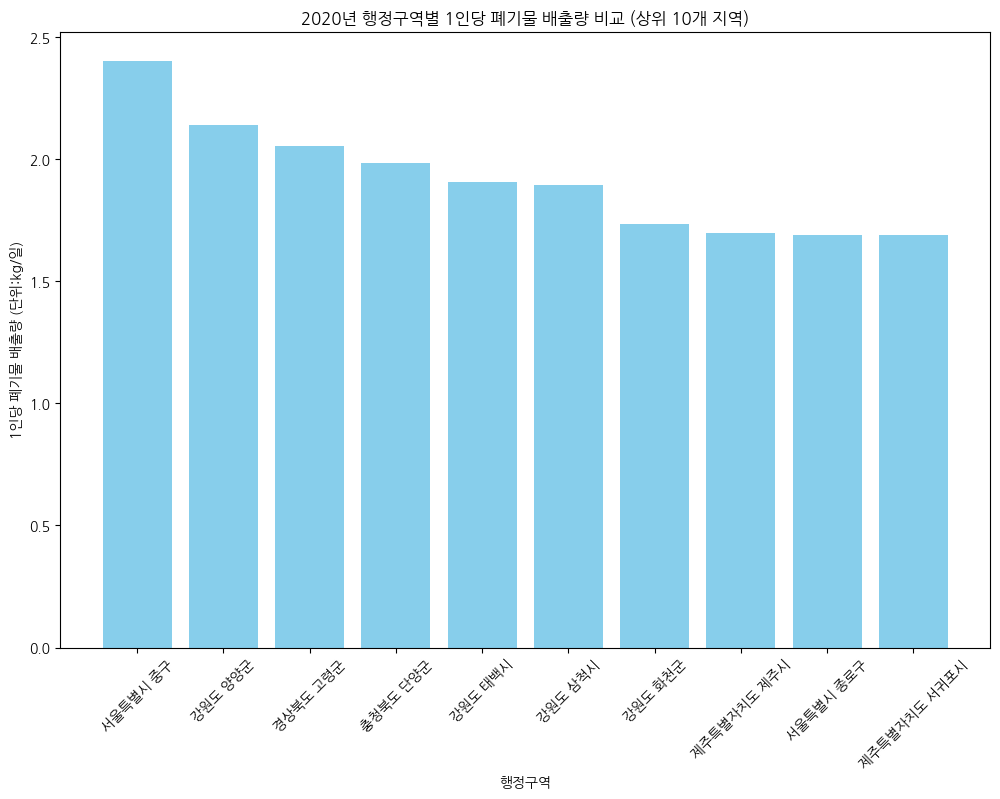

In [30]:
# import matplotlib.pyplot as plt

# 2014 ~ 2021

year = int(input())

# 1인당 폐기물 배출량 상위 10개 지역 데이터 준비
top_districts_per_capita = result[result['YEAR']==year].sort_values(by=['1인당 폐기물 배출량'], ascending=False).head(10)

# 일반적인 막대그래프 시각화
plt.figure(figsize=(12, 8))
plt.bar(top_districts_per_capita['행정구역'], top_districts_per_capita['1인당 폐기물 배출량'], color='skyblue')
plt.title(f'{year}년 행정구역별 1인당 폐기물 배출량 비교 (상위 10개 지역)')
plt.xlabel('행정구역')
plt.ylabel('1인당 폐기물 배출량 (단위:kg/일)')
plt.xticks(rotation=45)
plt.show()


In [72]:
df = result[result['시군구']=='합계'].reset_index(drop=True)

df.rename(columns = {'총계':'count'}, inplace=True)

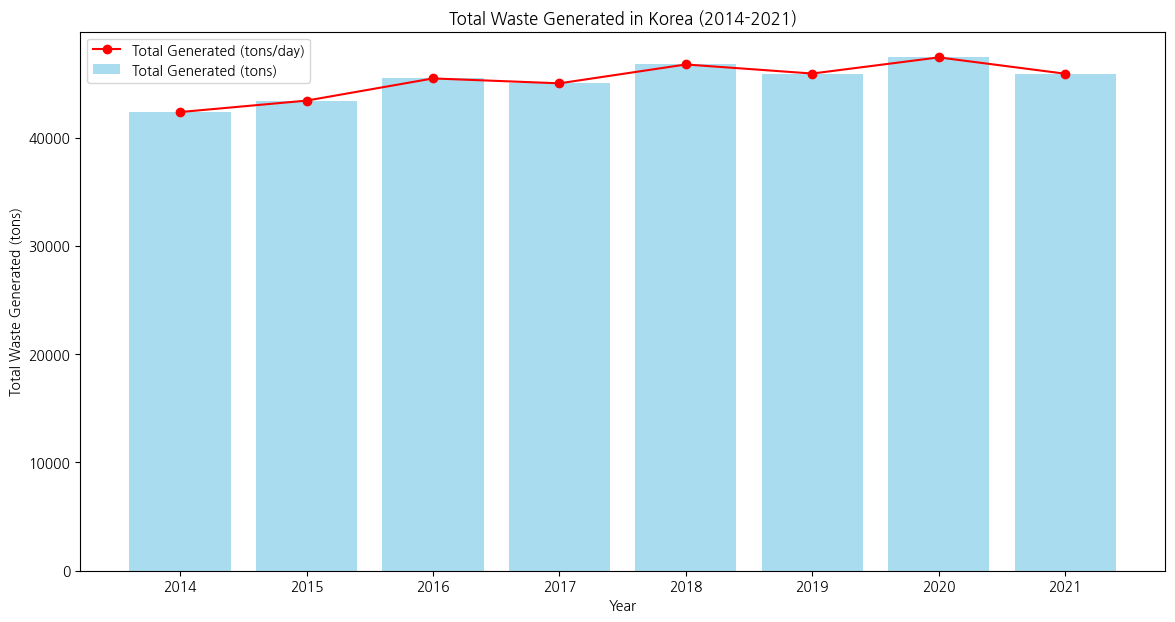

In [48]:
import matplotlib.pyplot as plt
# 그래프 크기 설정
plt.figure(figsize=(14, 7))

# plt.grid(True)

# 막대그래프
plt.bar(df['YEAR'], df['count'], color='skyblue', label='Total Generated (tons)', alpha=0.7)

# 꺾은선그래프
plt.plot(df['YEAR'], df['count'], color='r', marker='o', label='Total Generated (tons/day)')

# 제목과 레이블 추가
plt.title('Total Waste Generated in Korea (2014-2021)')
plt.xlabel('Year')
plt.ylabel('Total Waste Generated (tons)')
plt.legend()

# 그래프 표시

plt.show()

# 모델별 예측 시각화

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


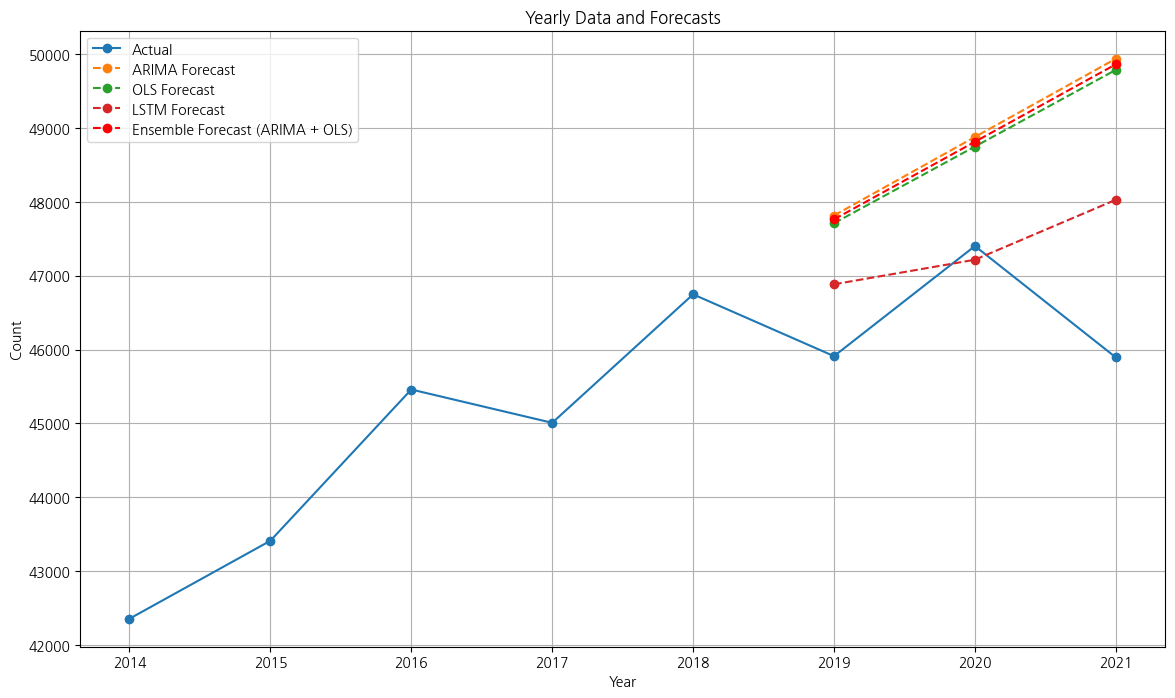

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# # 데이터 로드
# data = {
#     'YEAR': [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
#     'count': [42355.2, 43411.2, 45460.3, 45008.9, 46749.3, 45912.1, 47403.8, 45894.6]
# }
# df = pd.DataFrame(data)
# df.set_index('YEAR', inplace=True)

# ARIMA 모델 피팅 및 예측
arima_model = ARIMA(df['count'][:5], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=3)
# arima_forecast_years = [2022, 2023, 2024, 2025, 2026]
arima_forecast_years = [2019, 2020, 2021]
arima_forecast_df = pd.DataFrame({'YEAR': arima_forecast_years, 'ARIMA_Forecast': arima_forecast})
arima_forecast_df.set_index('YEAR', inplace=True)

# OLS 모델 피팅 및 예측
X = df['YEAR'][:5]
y = df['count'][:5]
X = sm.add_constant(X)
ols_model = sm.OLS(y, X).fit()
# forecast_years = [2022, 2023, 2024, 2025, 2026]
forecast_years = [2019, 2020, 2021]
forecast_years_with_const = sm.add_constant(forecast_years)
ols_forecast = ols_model.predict(forecast_years_with_const)
ols_forecast_df = pd.DataFrame({'YEAR': forecast_years, 'OLS_Forecast': ols_forecast})
ols_forecast_df.set_index('YEAR', inplace=True)

# # Prophet 모델 피팅 및 예측
# prophet_data = df.reset_index()[['YEAR', 'count']]
# prophet_data.columns = ['ds', 'y']
# prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')
# prophet_model = Prophet()
# prophet_model.fit(prophet_data)
# future = prophet_model.make_future_dataframe(periods=5, freq='Y')
# future['ds'] = future['ds'] + pd.offsets.YearEnd(0)  # 각 연도의 마지막 날로 설정
# prophet_forecast = prophet_model.predict(future)
# prophet_forecast['YEAR'] = prophet_forecast['ds'].dt.year
# prophet_forecast['YEAR'].iloc[-5:] += 1  # 마지막 5개의 연도에 대해 +1 적용
# prophet_forecast_df = prophet_forecast[prophet_forecast['YEAR'].isin(forecast_years)][['YEAR', 'yhat']]
# prophet_forecast_df.columns = ['YEAR', 'Prophet_Forecast']
# prophet_forecast_df.set_index('YEAR', inplace=True)

# LSTM 모델 피팅 및 예측
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['count']][:5])

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 3
X, Y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, Y, epochs=100, batch_size=1, verbose=0)  # verbose=0으로 설정하여 출력 생략

future_steps = 3
future_data = list(scaled_data[-time_step:])
lstm_forecast = []
for _ in range(future_steps):
    future_input = np.array(future_data[-time_step:]).reshape((1, time_step, 1))
    pred = model.predict(future_input, verbose=0)
    future_data.append(pred[0])
    lstm_forecast.append(pred[0])

lstm_forecast = scaler.inverse_transform(lstm_forecast).flatten()
# lstm_forecast_years = [2022, 2023, 2024, 2025, 2026]
lstm_forecast_years = [2019, 2020, 2021]
lstm_forecast_df = pd.DataFrame({'YEAR': lstm_forecast_years, 'LSTM_Forecast': lstm_forecast})
lstm_forecast_df.set_index('YEAR', inplace=True)

# 앙상블 예측 (ARIMA + OLS)
ensemble_forecast = (arima_forecast + ols_forecast) / 2
ensemble_forecast_df = pd.DataFrame({'YEAR': forecast_years, 'Ensemble_Forecast': ensemble_forecast})
ensemble_forecast_df.set_index('YEAR', inplace=True)

# 예측 결과 시각화
plt.figure(figsize=(14, 8))
plt.plot(df['YEAR'], df['count'].round(2), marker='o', label='Actual')
plt.plot(arima_forecast_df.index, arima_forecast_df['ARIMA_Forecast'].round(2), marker='o', linestyle='--', label='ARIMA Forecast')
plt.plot(ols_forecast_df.index, ols_forecast_df['OLS_Forecast'].round(2), marker='o', linestyle='--', label='OLS Forecast')
# plt.plot(prophet_forecast_df.index, prophet_forecast_df['Prophet_Forecast'].round(2), marker='o', linestyle='--', label='Prophet Forecast')
plt.plot(lstm_forecast_df.index, lstm_forecast_df['LSTM_Forecast'].round(2), marker='o', linestyle='--', label='LSTM Forecast')
plt.plot(ensemble_forecast_df.index, ensemble_forecast_df['Ensemble_Forecast'].round(2), marker='o', linestyle='--', color='red', label='Ensemble Forecast (ARIMA + OLS)')
plt.title('Yearly Data and Forecasts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


# ARIMA 모델 시각화

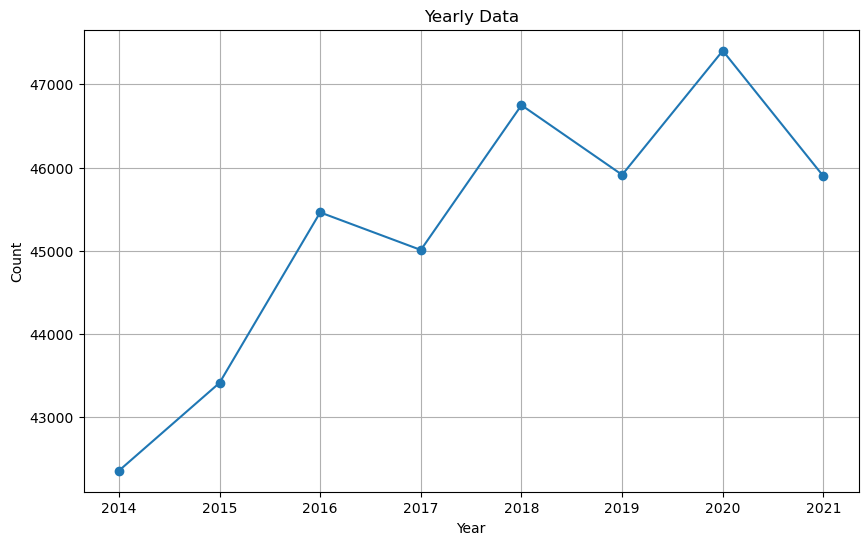

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                    8
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -58.280
Date:                Sat, 08 Jun 2024   AIC                            122.560
Time:                        15:54:01   BIC                            122.397
Sample:                             0   HQIC                           120.554
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.022    -44.977      0.000      -1.044      -0.956
ma.L1          0.9987      0.815      1.225      0.221      -0.599       2.597
sigma2      9.768e+05   8.34e-07   1.17e+12      0.0

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results wil

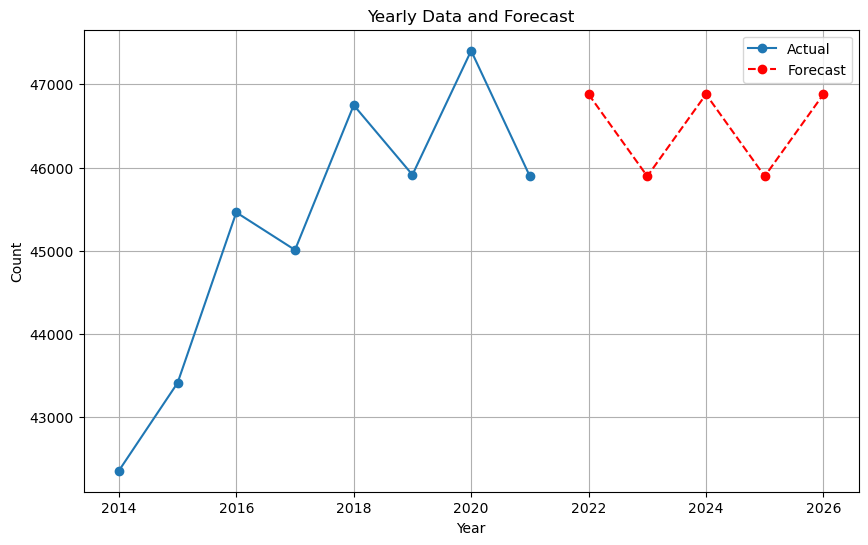

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df.set_index('YEAR', inplace=True)

# 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['count'], marker='o')
plt.title('Yearly Data')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# ARIMA 모델 피팅
model = ARIMA(df['count'], order=(1, 1, 1))
model_fit = model.fit()

# 요약 출력
print(model_fit.summary())

# 예측
forecast = model_fit.forecast(steps=5)  # 향후 5년 예측
forecast_years = [2022, 2023, 2024, 2025, 2026]
forecast_df = pd.DataFrame({'YEAR': forecast_years, 'Forecast': forecast})
forecast_df.set_index('YEAR', inplace=True)

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['count'], marker='o', label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], marker='o', linestyle='--', color='red', label='Forecast')
plt.title('Yearly Data and Forecast')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


# OLS 모델 시각화

                            OLS Regression Results                            
Dep. Variable:                   총계_계   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     13.67
Date:                Sat, 08 Jun 2024   Prob (F-statistic):             0.0101
Time:                        15:44:03   Log-Likelihood:                -65.449
No. Observations:                   8   AIC:                             134.9
Df Residuals:                       6   BIC:                             135.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.104e+06   3.11e+05     -3.551      0.0

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


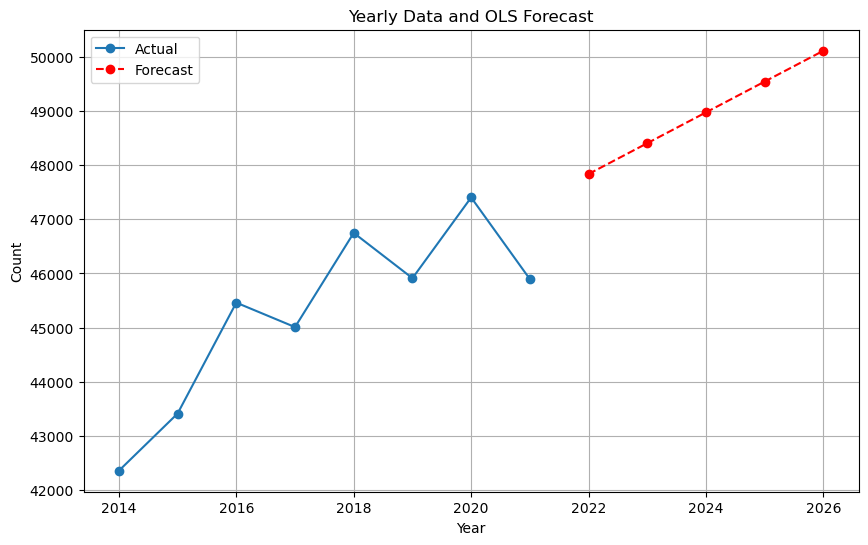

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 독립 변수와 종속 변수 설정
X = df_bak['YEAR']
y = df_bak['count']

# 독립 변수에 상수 항 추가
X = sm.add_constant(X)

# OLS 모델 피팅
model = sm.OLS(y, X).fit()

# 모델 요약 출력
print(model.summary())

# 예측
forecast_years = [2022, 2023, 2024, 2025, 2026]
forecast_years_with_const = sm.add_constant(forecast_years)
forecast = model.predict(forecast_years_with_const)
forecast_df = pd.DataFrame({'YEAR': forecast_years, 'Forecast': forecast})
forecast_df.set_index('YEAR', inplace=True)

# 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(df_bak['YEAR'], df_bak['총계_계'], marker='o', label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], marker='o', linestyle='--', color='red', label='Forecast')
plt.title('Yearly Data and OLS Forecast')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


# 앙상블모델

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results wil

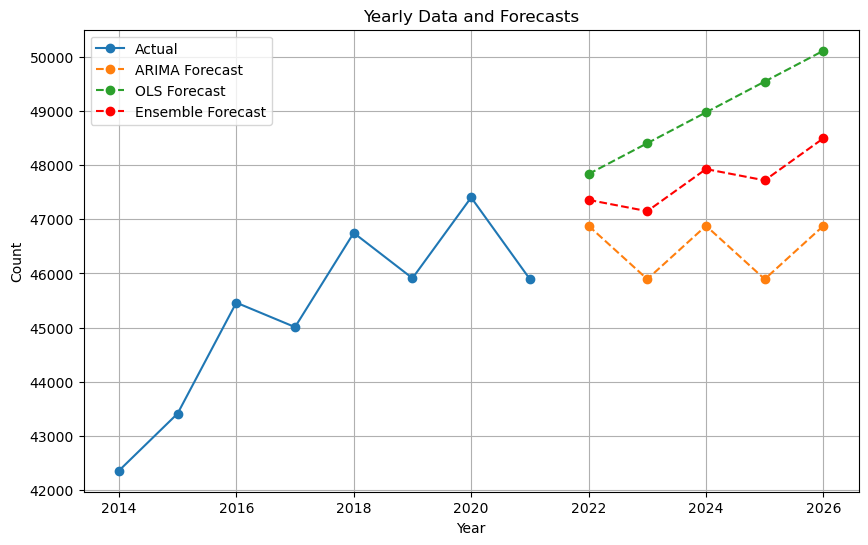

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# df = df_bak

# df.set_index('YEAR', inplace=True)

# ARIMA 모델 피팅
arima_model = ARIMA(df['총계_계'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=5)
arima_forecast_years = [2022, 2023, 2024, 2025, 2026]
arima_forecast_df = pd.DataFrame({'YEAR': arima_forecast_years, 'ARIMA_Forecast': arima_forecast})
arima_forecast_df.set_index('YEAR', inplace=True)

# OLS 모델 피팅
X = df.index
y = df['총계_계']
X = sm.add_constant(X)
ols_model = sm.OLS(y, X).fit()
forecast_years = [2022, 2023, 2024, 2025, 2026]
forecast_years_with_const = sm.add_constant(forecast_years)
ols_forecast = ols_model.predict(forecast_years_with_const)
ols_forecast_df = pd.DataFrame({'YEAR': forecast_years, 'OLS_Forecast': ols_forecast})
ols_forecast_df.set_index('YEAR', inplace=True)

# 앙상블 예측
ensemble_forecast_df = pd.DataFrame({
    'YEAR': forecast_years,
    'Ensemble_Forecast': (arima_forecast + ols_forecast) / 2
})
ensemble_forecast_df.set_index('YEAR', inplace=True)

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['총계_계'], marker='o', label='Actual')
plt.plot(arima_forecast_df.index, arima_forecast_df['ARIMA_Forecast'], marker='o', linestyle='--', label='ARIMA Forecast')
plt.plot(ols_forecast_df.index, ols_forecast_df['OLS_Forecast'], marker='o', linestyle='--', label='OLS Forecast')
plt.plot(ensemble_forecast_df.index, ensemble_forecast_df['Ensemble_Forecast'], marker='o', linestyle='--', color='red', label='Ensemble Forecast')
plt.title('Yearly Data and Forecasts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 인당 쓰레기 배출량
# 가장 배출량이 많은 시군구
